In [1]:
import pandas as pd
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

/Users/jerrychen/Desktop/GitHub/alphaswarm/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from alphaswarm.services.alchemy import AlchemyClient
from alphaswarm.tools.alchemy.alchemy_price_history import GetAlchemyPriceHistoryBySymbol
from alphaswarm.services.alchemy import HistoricalPriceBySymbol

In [98]:
total_days = 130
num_y = 30

alchemy_client = AlchemyClient.from_env()
tool = GetAlchemyPriceHistoryBySymbol(alchemy_client)
gold_result = tool.forward(symbol="WETH", interval="1d", history=total_days)

# use the first 6 days data as input to the forecaster
historical_data = HistoricalPriceBySymbol(symbol=gold_result.symbol, data=[p for p in gold_result.data[:-num_y]])

In [99]:
len(historical_data.data)

100

In [100]:
def transform_historical_price_to_dataframe(price_data: HistoricalPriceBySymbol) -> pd.DataFrame:

    # Create empty lists to store the data
    item_ids = []
    timestamps = []
    target_values = []
    
    # Extract data from the HistoricalPriceBySymbol object
    symbol = price_data.symbol
    
    # Iterate through each HistoricalPrice in the data list
    for price_point in price_data.data:
        item_ids.append(symbol)
        # Format the timestamp to include date with a consistent time of 01:00:00
        date_with_time = f"{price_point.timestamp.strftime('%Y-%m-%d %H:%M:%S')}"
        timestamps.append(date_with_time)
        target_values.append(float(price_point.value))  # Convert Decimal to float
    
    # Create the DataFrame
    df = pd.DataFrame({
        'item_id': item_ids,
        'timestamp': pd.to_datetime(timestamps),  # Convert strings to naive datetime
        'target': target_values
    })
    
    return df

In [101]:
# Transform the data into a DataFrame for use with AutoGluon
train_df = transform_historical_price_to_dataframe(historical_data)


In [102]:
train_data = TimeSeriesDataFrame.from_data_frame(
    train_df,
    id_column="item_id",
    timestamp_column="timestamp"
)
train_data.head()

target
item_id timestamp              
WETH    2024-10-29  2565.628907
        2024-10-30  2640.455269
        2024-10-31  2659.115539
        2024-11-01  2515.351162
        2024-11-02  2513.200004

In [103]:
predictor = TimeSeriesPredictor(
    prediction_length=num_y,
    path="autogluon-forecast-weth-1d-v0",
    target="target",
    eval_metric="MASE",
)

predictor.fit(
    train_data,
    presets="medium_quality",
    time_limit=500,
)

Beginning AutoGluon training... Time limit = 500s
AutoGluon will save models to '/Users/jerrychen/Desktop/GitHub/alphaswarm/tests/integration/tools/alchemy/autogluon-forecast-weth-1d-v0'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.12.4
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 24.3.0: Thu Jan  2 20:24:23 PST 2025; root:xnu-11215.81.4~3/RELEASE_ARM64_T6020
CPU Count:          12
GPU Count:          0
Memory Avail:       8.11 GB / 32.00 GB (25.3%)
Disk Space Avail:   211.50 GB / 460.43 GB (45.9%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'hyperparameters': 'light',
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 30,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'tar

In [104]:
predictions = predictor.predict(train_data)
predictions.head()

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


mean          0.1          0.2          0.3  \
item_id timestamp                                                        
WETH    2025-02-06  3164.295335  2612.387615  2795.000418  2939.790404   
        2025-02-07  3185.499545  2434.620896  2684.842499  2879.831894   
        2025-02-08  3193.449663  2290.011905  2592.271086  2825.518319   
        2025-02-09  3170.123564  2137.862193  2483.835360  2749.582586   
        2025-02-10  3128.554147  1978.426751  2370.699816  2656.710882   

                            0.4          0.5          0.6          0.7  \
item_id timestamp                                                        
WETH    2025-02-06  3052.323593  3164.295335  3272.861560  3386.859043   
        2025-02-07  3035.863744  3185.499545  3332.086793  3489.828207   
        2025-02-08  3015.138357  3193.449663  3368.973189  3560.740108   
        2025-02-09  2967.768414  3170.123564  3370.538101  3591.048636   
        2025-02-10  2891.966246  3128.554147  3353.580311  3592.710736   

                            0.8          0.9  
item_id timestamp                             
WETH    2025-02-06  3520.952588  3719.673179  
        2025-02-07  3674.204900  3941.045339  
        2025-02-08  3784.088323  4102.825074  
        2025-02-09  3846.880060  4209.265489  
        2025-02-10  3875.884248  4278.756617

In [105]:
test_df = transform_historical_price_to_dataframe(HistoricalPriceBySymbol(symbol=gold_result.symbol, data=[p for p in gold_result.data[-num_y:]]))
# combined_data = pd.concat([train_df, test_df])

combined_data = TimeSeriesDataFrame.from_data_frame(
    pd.concat([train_df, test_df]),
    id_column="item_id",
    timestamp_column="timestamp"
)

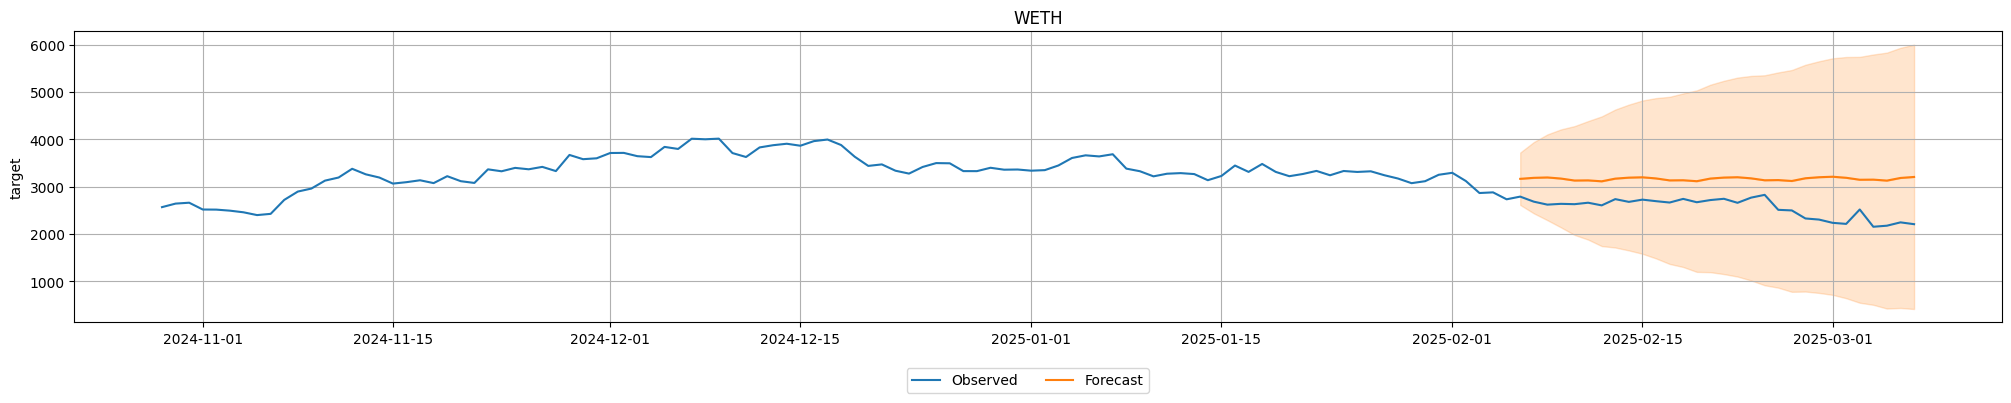

In [110]:
predictor.plot(combined_data, predictions, quantile_levels=[0.1, 0.9], max_history_length=200, max_num_item_ids=4)

In [111]:
predictor.leaderboard(combined_data)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,Naive,-0.799813,-1.500418,0.631370,1.713593,0.006403,1
1,ETS,-0.799849,-1.500426,0.601033,0.581404,0.004838,5
2,Theta,-0.827619,-1.703797,7.388228,7.857099,0.004878,6
3,Chronos[bolt_small],-1.051096,-1.824412,0.841070,0.829695,0.005208,7
4,SeasonalNaive,-2.046521,-1.003849,0.928318,0.600101,0.004808,2
5,DirectTabular,-2.403849,-0.573488,0.035505,0.021103,0.225778,4
6,WeightedEnsemble,-2.537991,-0.436271,1.621096,2.341909,0.091661,9
7,RecursiveTabular,-4.057692,-3.449275,0.099785,0.104191,0.293271,3
8,TemporalFusionTransformer,-4.590141,-1.473162,0.024037,0.007112,75.912932,8


In [116]:
from autogluon.timeseries.metrics import RMSE, MAPE, MASE

metric = MAPE()
# metric.save_past_metrics(train_data)
metric.compute_metric(combined_data.iloc[-num_y:], predictions)


0.2482167355202839